# Graph Neural Networks For Numerical Weather Prediction (Maybe change title)
# Graph Neural Networks for Weather and Climate

- Lewis Lee
- Met Office

---

## Overview 

Graphs are a useful way to represent objects and their connections to other things. Graph neural networks (GNNs) allow us to use the abilities of deep learning and neural networks on data and problems that can be structured as graphs. This is becoming particularly important for weather and climate data science as they can effectively utilise the relational inductive bias that graph neural networks provide. 

### Prerequisites
- **Python Programming**: Proficiency in Python is essential, as it is the primary language used throughout this tutorial.
- **Basics of Deep Learning**: A solid understanding of key concepts such as feed-forward neural networks, backpropagation, and optimization techniques is necessary for grasping the fundamentals of Graph Neural Networks (GNNs).
- **Data Science Libraries**: Familiarity with essential Python libraries like Pandas, NumPy, Xarray, and Matplotlib is required for data manipulation, analysis, and visualization tasks.
- **Machine Learning Framework (Optional)**: While not mandatory, having experience with a machine learning framework such as TensorFlow or PyTorch will be beneficial. This will help you more easily understand the implementation and training of the example GNN model.

### Learning Outcomes
- Learn how to structure graph data for machine learning 
- Understand what graph neural networks are

### Getting Started
**Conda Environment:** The conda environment used for this notebook is requirements_tensorflow-gnn.yml in the env directory. The name of the conda environment is data-science-cop-tfgnn. Follow the [creating an environment from an environment yml file](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) documentation from Conda or example below.

```bash
conda env create -f env/requirements_tensorflow-gnn.yml

conda activate data-science-cop-tfgnn
```

## Tutorial Material

### Graphs 

A graph is a way to represent a set of objects (nodes/vertices), and the connections between them (edges). To be able to use graph data in a neural network we need to represent it in a suitable format. Mathematically, a graph $G$ is defined as a tuple of a set of nodes/vertices $V$, and a set of edges $E$: $G = (V, E)$. Each edge is a pair of two nodes, and represents a connection between them.

For example, the graph ... 

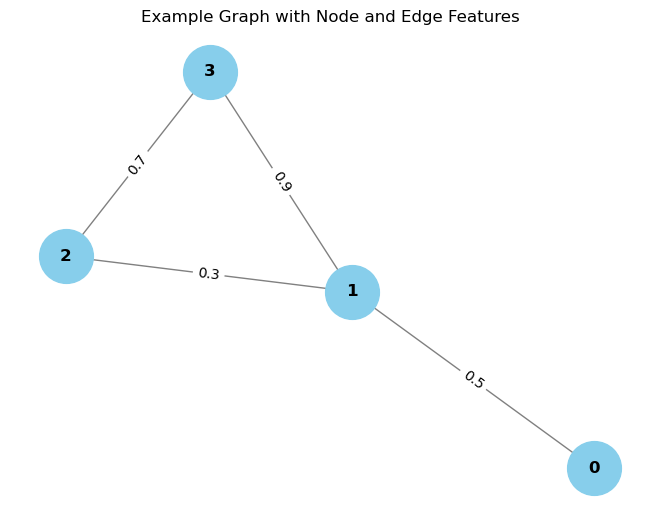

In [111]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()

# Add nodes with features
G.add_node(0, feature=[1])
G.add_node(1, feature=[0])
G.add_node(2, feature=[2])
G.add_node(3, feature=[1])

# Add edges with features
G.add_edge(0, 1, weight=0.5)
G.add_edge(1, 2, weight=0.3)
G.add_edge(1, 3, weight=0.9)
G.add_edge(2, 3, weight=0.7)

# Define a global feature for the graph
global_feature = [1]

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='gray', font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]}' for u, v, d in G.edges(data=True)})

plt.title("Example Graph with Node and Edge Features")
plt.show()

... can be represented as the following tuples (this doesn't represent the features of the nodes or edges).

$V =\{0,1,2,3\}$

$E =\{(0,1),(1,2),(1,3),(2,3)\}$

Note that for simplicity, we assume the graph to be undirected and hence don't add mirrored pairs like $(1,2)$ and $(2,1)$. In application, vertices and edge can often have specific attributes/features, and edges can even be directed. 

One way of representing a graph is by using an **adjacency matrix** $A$ which is a square matrix whose elements indicate whether pairs of vertices are adjacent/connected or not. In the simplest case, $A_{ij}$ is 1 if there is a connection from node $i$ to $j$, and otherwise 0. If we have edge attributes or different categories of edges in a graph, this information can be added to the matrix as well. For an undirected graph, keep in mind that $A$ is a symmetric matrix ($A_{ij} = A_{ji}$). For the example graph above, we have the following adjacency matrix (for simplicity this does not include the features of the graph).

$$A = \begin{bmatrix}
    0 & 1 & 0 & 0\\
    1 & 0 & 1 & 1\\
    0 & 1 & 0 & 1\\
    0 & 1 & 1 & 0
\end{bmatrix}$$

A more memory-efficient way of expressing a graph is as adjacency lists. These describe the connectivity of edge $e_k$ between nodes $n_i$ and $n_j$ as a tuple ($i$,$j$) in the $k$th entry of an adjacency list. Since we expect the number of edges to be much lower than the number of entries for an adjacency matrix ($n^2_\text{nodes}$), we avoid computation and storage on the disconnected parts of the graph. 

Typical attributes of a graph are:
- **nodes:** Node features for each node in the graph 
- **edge:** Edge features for each edge in the graph. 
- **adjacencies:** Indices of the nodes in the nodes, which indicate the source node of each directed edge in edges.
- **globals**: Global features for each graph

For our example:
- $\text{nodes}=\{1,0,2,1\}$
- $\text{edges}=\{0.5,0.3,0.9,0.7\}$
- $\text{adjacencies}=\{(0,1),(1,2),(1,3),(2,3)\}$
- $\text{globals}=\{1\}$

You can change the code in the example above to see how it changes the graph. 
Note that in this example the the features of the nodes and edges are simple floats and integers but they can be more complex like tensors.

### Graph Neural Networks 
Graph Neural Networks (GNNs) are a class of neural networks designed to operate on graph-structured data. They extend the principles of neural networks to data that can be represented as graphs, capturing the relationships and dependencies between nodes through the graph's edges. GNNs use various methods to aggregate and propagate information across the graph, allowing them to learn representations for nodes, edges, or entire graphs. GNNs can be used for various tasks such as classification, clustering, and prediction. These tasks can also be performed at different levels of the graph like the nodes, edges and global levels.

##### Types of GNNs
A graph neural network is the overarching concept of using aggregate and pass information throughout a graph and process it with neural networks but there are many different GNN architectures.

**GNN Examples:**
- Graph Convolution Network (GCN)
- Graph Attention Network (GAT)
- Graph Recurrent Neural Network (Graph RNN)
- Graph Autoencoders
- etc

## Example - Weather Buoy Network

The [Irish Weather Buoy Network](https://data.gov.ie/dataset/weather-buoy-network) is a network of 5 weather buoys around Ireland. These weather buoys are moored surface buoys with instruments which collect weather and ocean data including air temperature, atmospheric humidity, sea surface temperature, sea temperature and salinity on moored chain, wave statistics and wind speed/direction.

There have been incomplete data observations for periods when the weather buoys were offline for maintenance and or damage from adverse weather conditions such as storms. The challenge is to predict the missing data during these downtime periods, using the data available from the other functioning buoys. By accurately filling in these gaps, we can ensure a continuous and comprehensive dataset, which is crucial for applications such as weather forecasting, marine navigation, and climate research. 

This problem can be efficiently represented as graph where the weather buoy stations are the nodes and the distances between them are the edges connecting them. We will be training a graph neural network to predict the values of missing variables such as atmosphere pressure, sea temperature and wave height (all variables listed below) from a specific weather buoy station (node) using the variables from surrounding buoys that are connected by edges that represent the distance between them. I will go into more detail into how the graph and data are structured later in the notebook. 

### Setup

In [112]:
import warnings
warnings.filterwarnings('ignore')

In [113]:
import pandas as pd
import numpy as np

In [114]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [115]:
import tensorflow as tf
import keras
import tensorflow_gnn as tfgnn
from tensorflow_gnn.models import vanilla_mpnn
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import networkx as nx
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Load Data

In [116]:
df = pd.read_parquet("./data/weather_buoy.parquet")
df

,station_id,longitude,latitude,time,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,MeanWaveDirection,Hmax,AirTemperature,DewPoint,SeaTemperature,RelativeHumidity,QC_Flag
1,M1,-11.200000,53.126600,2001-02-06T13:00:00Z,967.600,270.0,21.980,33.100,NaN,NaN,NaN,NaN,8.900,NaN,9.000,NaN,1.0
2,M1,-11.200000,53.126600,2001-02-06T14:00:00Z,969.800,270.0,23.930,35.000,NaN,NaN,NaN,NaN,8.500,NaN,9.000,NaN,1.0
3,M1,-11.200000,53.126600,2001-02-06T15:00:00Z,972.000,270.0,19.070,31.100,NaN,NaN,NaN,NaN,8.900,NaN,9.000,NaN,1.0
4,M1,-11.200000,53.126600,2001-02-06T16:00:00Z,973.600,270.0,15.950,25.300,NaN,NaN,NaN,NaN,9.100,NaN,9.000,NaN,1.0
5,M1,-11.200000,53.126600,2001-02-06T18:00:00Z,976.400,270.0,12.060,19.500,NaN,NaN,NaN,NaN,8.800,NaN,9.000,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866467,M2,-5.430200,53.483600,2024-07-11T12:00:00Z,1020.386,0.0,14.686,19.582,1.172,4.922,357.0,1.719,12.998,NaN,12.913,83.594,0.0
866468,M3,-10.548261,51.215956,2024-07-11T12:00:00Z,1024.097,334.0,15.939,19.013,1.406,4.336,336.0,2.031,13.975,NaN,14.381,81.348,0.0
866469,M4,-9.999136,54.999967,2024-07-11T12:00:00Z,1025.037,347.0,10.132,12.751,1.523,4.570,4.0,2.344,12.900,NaN,13.310,75.000,0.0
866470,M5,-6.704336,51.690425,2024-07-11T12:00:00Z,1021.118,352.0,17.874,22.770,1.172,3.984,301.0,2.344,12.949,NaN,15.172,84.961,0.0


The weather buoy network data consists of 17 columns, including station ID, longitude, latitude, and 14 weather variables (as shown in the cell below). Before transforming this data into a graph structure, it must be preprocessed to ensure suitability for machine learning.

In [117]:
# Display the column of the dataframe 
df.keys()

Index(['station_id', 'longitude', 'latitude', 'time', 'AtmosphericPressure',
       'WindDirection', 'WindSpeed', 'Gust', 'WaveHeight', 'WavePeriod',
       'MeanWaveDirection', 'Hmax', 'AirTemperature', 'DewPoint',
       'SeaTemperature', 'RelativeHumidity', 'QC_Flag'],
      dtype='object')

### Clean Data

['M1' 'M2' 'M3' 'FS1' 'M4-Archive' 'M5' 'M6' 'M4' 'Belmullet-AMETS']
[51626, 173292, 155075, 28539, 31215, 155760, 133176, 135057, 2731]


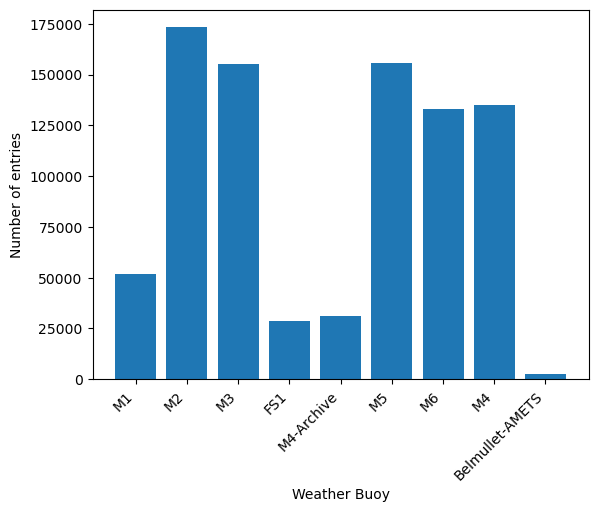

In [118]:
station_list = df['station_id'].unique()
station_values = []
for station_name in station_list:
    count = len(df[df['station_id'] == station_name])
    station_values.append(count)

print(station_list)
print(station_values)

plt.bar(station_list, station_values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Weather Buoy')
plt.ylabel('Number of entries')
plt.show()

For our dataset, we aim to ensure that data readings are available from all weather buoys for each time step. This is important for establishing a ground truth to compare against the model's predictions. However, some weather buoys have significantly fewer readings than others, primarily because they are older and no longer in operation. Removing these stations with fewer entries will slightly reduce the overall amount of data but will enable us to work exclusively with data where readings from all buoys are present.

In [119]:
# Only keep operational weather buoy stations
df_filtered = df[df['station_id'].isin(['M2', 'M3', 'M4', 'M5', 'M6'])]

# Remove unneeded column
df_filtered = df_filtered.drop(['QC_Flag'], axis=1)
df_filtered

,station_id,longitude,latitude,time,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,MeanWaveDirection,Hmax,AirTemperature,DewPoint,SeaTemperature,RelativeHumidity
1890,M2,-5.430200,53.483600,2001-05-03T14:00:00Z,1014.800,350.0,7.980,11.700,1.100,4.000,NaN,NaN,8.600,5.8,8.800,82.500
1892,M2,-5.430200,53.483600,2001-05-03T15:00:00Z,1014.600,360.0,NaN,11.700,1.000,4.000,NaN,NaN,8.700,NaN,8.900,NaN
1894,M2,-5.430200,53.483600,2001-05-03T16:00:00Z,1014.200,350.0,7.980,11.700,1.000,5.000,NaN,NaN,8.800,5.0,8.700,77.000
1896,M2,-5.430200,53.483600,2001-05-03T17:00:00Z,1014.200,360.0,8.950,11.700,0.800,5.000,NaN,NaN,8.800,5.1,8.700,77.600
1898,M2,-5.430200,53.483600,2001-05-03T18:00:00Z,1014.000,360.0,7.980,11.700,0.800,5.000,NaN,NaN,8.900,5.8,8.600,80.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866467,M2,-5.430200,53.483600,2024-07-11T12:00:00Z,1020.386,0.0,14.686,19.582,1.172,4.922,357.0,1.719,12.998,NaN,12.913,83.594
866468,M3,-10.548261,51.215956,2024-07-11T12:00:00Z,1024.097,334.0,15.939,19.013,1.406,4.336,336.0,2.031,13.975,NaN,14.381,81.348
866469,M4,-9.999136,54.999967,2024-07-11T12:00:00Z,1025.037,347.0,10.132,12.751,1.523,4.570,4.0,2.344,12.900,NaN,13.310,75.000
866470,M5,-6.704336,51.690425,2024-07-11T12:00:00Z,1021.118,352.0,17.874,22.770,1.172,3.984,301.0,2.344,12.949,NaN,15.172,84.961


In [120]:
# Shows the total amount of null values per feature
null_values = df_filtered.isnull().sum()
null_values

station_id                  0
longitude                   0
latitude                    0
time                        0
AtmosphericPressure     16956
WindDirection           59032
WindSpeed               91184
Gust                   106841
WaveHeight             104710
WavePeriod             103016
MeanWaveDirection      422351
Hmax                   415694
AirTemperature          34877
DewPoint               435000
SeaTemperature          56539
RelativeHumidity       100310
dtype: int64

This data has a lot of null values that need to be dealt with before the data can be used to train the model. As this is time series data interpolation will work well to replace most of the missing values.
Additionally, some of the features have nearly 50% missing values. This could largely effect the performance of the model so MeanWaveDirection, Hmax and DewPoint will be removed. 

In [121]:
# Drop the columns with mostly null values. 
df_filtered = df_filtered.drop(['MeanWaveDirection', 'Hmax', 'DewPoint'], axis=1)

time_counts = df_filtered['time'].value_counts()
common_times = time_counts[time_counts == 5].index

df_common_times = df_filtered[df_filtered['time'].isin(common_times)]

df_interpolated = df_common_times.groupby('station_id').apply(lambda group: group.interpolate(method='linear'))
df_interpolated = df_interpolated.reset_index(drop=True)

df_interpolated = df_interpolated.fillna(method='ffill')
df = df_interpolated.fillna(method='bfill')

# Shows the new total amount of null values per feature
null_values = df.isnull().sum()
null_values

station_id             0
longitude              0
latitude               0
time                   0
AtmosphericPressure    0
WindDirection          0
WindSpeed              0
Gust                   0
WaveHeight             0
WavePeriod             0
AirTemperature         0
SeaTemperature         0
RelativeHumidity       0
dtype: int64

### Creating the Graph Data
Currently the data is in a tabular format where the rows are single readings from a station and the columns are time of the reading, longitude, latitude, AtmosphericPressure, WindDirection, etc. We need to restructure the data to be suitable for a graph. 

The weather station buoys are moored and therefore there is a small amount of movement but they don't have any major changes in their longitude or latitude. So for simplicity we will be precalculating the average indices and distances which will be used for the connectivity and edge features of the graph. This will likely not have any effect on performance for our example as the difference in position is minor so there will be no impactful change in the neighbours or distance. 

We will be using the K-nearest neighbours (KNN) algorithm to calculate the nearest stations and distances using the average longitude and latitude from the data. One problem that this causes is that it creates edges between nodes where the connection goes across land. As the benefit of using a GNN for this 

In [122]:
# Calculate the average distance between each station
average_coordinates = df.groupby('station_id')[['longitude', 'latitude']].mean()
X = average_coordinates.values

knn = NearestNeighbors(n_neighbors=3)
knn.fit(average_coordinates)

distances, indices = knn.kneighbors(average_coordinates)

distances, indices

(array([[0.        , 2.19974979, 4.81399471],
        [0.        , 3.82364715, 3.87309698],
        [0.        , 3.82364715, 4.66998665],
        [0.        , 2.19974979, 3.87309698],
        [0.        , 5.64776183, 6.18923521]]),
 array([[0, 3, 2],
        [1, 2, 3],
        [2, 1, 3],
        [3, 0, 1],
        [4, 1, 2]]))

As the nodes are weather buoy station around Ireland, buoys shouldn't have edges that connect over land. We can manually remove these connections by setting removed edges to -1.

In [123]:
# Function to remove an edge
def remove_edge(indices, distances, node_from, node_to):
    # Find the row in the indices list that corresponds to node_from
    for i, row in enumerate(indices):
        if row[0] == node_from:
            # Find the index of the node_to in the row
            idx = np.where(row == node_to)[0]
            if idx.size > 0:
                idx = idx[0]
                # Remove the edge from the indices list
                new_indices_row = np.delete(indices[i], idx)
                # Remove the corresponding distance
                new_distances_row = np.delete(distances[i], idx)
                # Update the indices and distances arrays
                indices[i] = np.pad(new_indices_row, (0, indices.shape[1] - new_indices_row.shape[0]), 'constant', constant_values=-1)
                distances[i] = np.pad(new_distances_row, (0, distances.shape[1] - new_distances_row.shape[0]), 'constant', constant_values=-1)
            break

remove_edge(indices, distances, 0, 2)
remove_edge(indices, distances, 2, 3)

distances, indices

(array([[ 0.        ,  2.19974979, -1.        ],
        [ 0.        ,  3.82364715,  3.87309698],
        [ 0.        ,  3.82364715, -1.        ],
        [ 0.        ,  2.19974979,  3.87309698],
        [ 0.        ,  5.64776183,  6.18923521]]),
 array([[ 0,  3, -1],
        [ 1,  2,  3],
        [ 2,  1, -1],
        [ 3,  0,  1],
        [ 4,  1,  2]]))

In [124]:
# Create an empty graph
G = nx.Graph()

# Add nodes with positions
for station_id, row in average_coordinates.iterrows():
    G.add_node(station_id, pos=(row['longitude'], row['latitude']))

# Add edges based on distances and indices
for i, (dist_row, idx_row) in enumerate(zip(distances, indices)):
    for j, (dist, idx) in enumerate(zip(dist_row[1:], idx_row[1:])):  # Skip first column (always 0)
        if dist != -1 and idx != -1:
            G.add_edge(average_coordinates.index[i], average_coordinates.index[idx], weight=round(dist, 2))

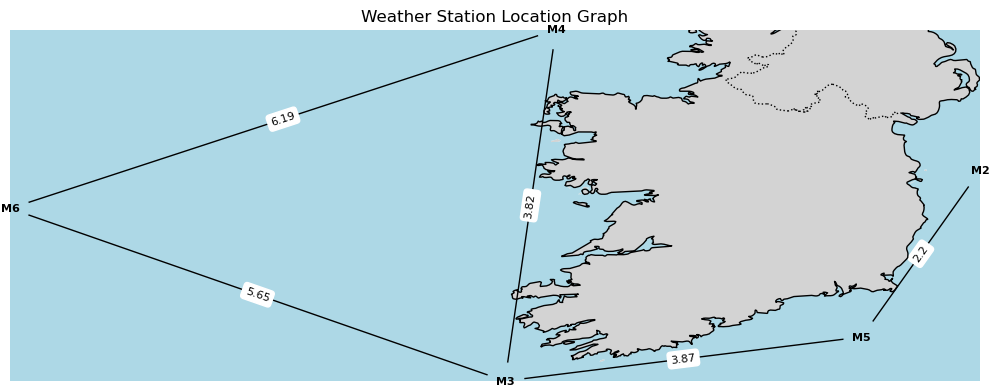

In [125]:
# Define the coordinate bounds based on your dataset
min_lon = average_coordinates['longitude'].min()
max_lon = average_coordinates['longitude'].max()
min_lat = average_coordinates['latitude'].min()
max_lat = average_coordinates['latitude'].max()

# Create a figure and axis using Cartopy with a PlateCarree projection
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent of the map to match the bounds of your data
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Add natural earth features for better map visualization
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Get the node positions (which are in longitude and latitude)
pos = nx.get_node_attributes(G, 'pos')

# Convert node positions into the map's coordinate system (PlateCarree)
transformed_pos = {node: ax.projection.transform_point(lon, lat, ccrs.PlateCarree())
                   for node, (lon, lat) in pos.items()}

# Draw the network graph on the map using the transformed positions
nx.draw(G, transformed_pos, with_labels=True, node_color='lightblue', node_size=700, font_size=8, font_weight='bold', ax=ax)

# Adjust node labels to avoid overlap
label_pos = {node: (coords[0], coords[1] - 0.15) for node, coords in transformed_pos.items()}

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=transformed_pos, edge_labels=edge_labels, font_size=8, ax=ax)

# Add a title and finalize the plot
plt.title('Weather Station Location Graph')
plt.tight_layout()
plt.show()


In [126]:
# Display the cleaned data
df

,station_id,longitude,latitude,time,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,AirTemperature,SeaTemperature,RelativeHumidity
0,M2,-5.43020,53.48360,2007-05-03T09:00:00Z,1019.600,60.0,7.000,10.000,0.300,5.000,10.200,9.700,94.000
1,M2,-5.43020,53.48360,2007-05-03T10:00:00Z,1019.800,40.0,8.000,10.000,0.300,5.000,10.100,9.700,94.000
2,M2,-5.43020,53.48360,2007-05-03T12:00:00Z,1019.800,60.0,9.000,11.000,0.400,4.000,10.100,9.900,94.000
3,M2,-5.43020,53.48360,2007-05-03T13:00:00Z,1020.000,20.0,8.000,12.000,0.400,3.000,10.000,9.900,94.000
4,M2,-5.43020,53.48360,2007-05-03T14:00:00Z,1020.000,20.0,7.000,10.000,0.400,3.000,10.100,10.100,94.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
388135,M6,-15.88135,53.07482,2024-07-11T08:00:00Z,1027.698,348.0,9.677,12.523,1.172,5.156,13.584,14.145,76.465
388136,M6,-15.88135,53.07482,2024-07-11T09:00:00Z,1028.003,354.0,9.905,12.068,1.172,4.922,13.584,14.130,75.879
388137,M6,-15.88135,53.07482,2024-07-11T10:00:00Z,1028.247,347.0,8.197,10.588,1.172,5.039,13.633,14.167,75.098
388138,M6,-15.88135,53.07482,2024-07-11T11:00:00Z,1028.577,338.0,9.108,11.612,1.172,5.156,13.730,14.242,74.512


### Data Preparation
Now that the data has been cleaned we will perform the final preprocessing such as normalization and convert the dataframe into tensor dataset so that we can later convert them into graph tensors.


In [127]:
# Standardize the data
standardScaler = StandardScaler()
# 4 is the index of AtmosphericPressure, the first feature that we want to standardize
df_norm = pd.DataFrame(standardScaler.fit_transform(df.iloc[:, 4:]), 
                       columns=df.iloc[:, 4:].columns,
                       index=df.iloc[:, 4:].index)

# Concatenate the non-normalized part with the normalized part
df_not_norm = df.iloc[:, :4]
df = pd.concat([df_not_norm, df_norm], axis=1)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,388140.0,-9.712657e+00,3.639304,-15.881350,-10.548261,-9.999136,-6.704336,-5.430200
latitude,388140.0,5.289295e+01,1.347580,51.215956,51.690425,53.074820,53.483600,54.999967
AtmosphericPressure,388140.0,9.474621e-13,1.000001,-8.803825,-0.593639,0.109505,0.703514,2.822691
WindDirection,388140.0,4.662994e-16,1.000001,-2.266209,-0.612979,0.158528,0.753691,1.701543
WindSpeed,388140.0,3.646479e-14,1.000001,-2.249362,-0.769269,-0.033433,0.693835,6.171167
Gust,388140.0,-9.836369e-15,1.000001,-2.228196,-0.724253,-0.079706,0.658086,5.936066
WaveHeight,388140.0,9.319515e-13,1.000001,-1.506834,-0.727126,-0.201937,0.491088,9.221940
WavePeriod,388140.0,-6.385308e-13,1.000001,-3.582185,-0.735282,-0.027260,0.583595,5.897616
AirTemperature,388140.0,2.665053e-14,1.000001,-4.106620,-0.704403,0.069787,0.797527,3.807721
SeaTemperature,388140.0,-4.404989e-13,1.000001,-5.945127,-0.808154,-0.017958,0.796423,3.565598


In [128]:
%%time

group_size = 5  # The number of weather buoy stations

result = (df.drop('longitude', axis=1) # Remove the longitude
            .drop('latitude', axis=1) # Remove the latitude
            .groupby('time') # Group all entries with the same time
            .filter(lambda x: x['station_id'].nunique() == group_size) # Filter out groups where not all stations are in the group
            .groupby('time') # Group all entries with the same time
            .apply(lambda x: x.drop(columns='time').to_dict(orient='list')) # Remove the time and convert to a dict
            )

result

CPU times: user 1min 6s, sys: 401 ms, total: 1min 6s
Wall time: 1min 7s


time
2007-05-03T09:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
2007-05-03T10:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
2007-05-03T12:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
2007-05-03T13:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
2007-05-03T14:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
                                              ...                        
2024-07-11T08:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
2024-07-11T09:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
2024-07-11T10:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
2024-07-11T11:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
2024-07-11T12:00:00Z    {'station_id': ['M2', 'M3', 'M4', 'M5', 'M6'],...
Length: 77628, dtype: object

In [129]:
ground_truth_list = []
input_list = []
for time, group in result.items():
    if len(group['station_id']) == group_size:
        rand_num = np.random.randint(0, 4) # The index of the stations are 0 to 4
        # The [1:] is to remove the station_id
        ground_truth_list.append([v for k, v in group.items()][1:])
        # One of the stations features are masked with 0s
        input_list.append([v[:rand_num] + [0] +  v[rand_num+1:] for _, v in group.items()][1:])

# Convert the lists into tf tensors
ground_truth_tensor = tf.convert_to_tensor(ground_truth_list)
input_tensor = tf.convert_to_tensor(input_list)

# Change the shape of the tensors from [time/batch, features, station] to [time/batch, station, features]
input_tensor = tf.transpose(input_tensor, perm=[0, 2, 1])
ground_truth_tensor = tf.transpose(ground_truth_tensor, perm=[0, 2, 1])

input_tensor

<tf.Tensor: shape=(77628, 5, 9), dtype=float32, numpy=
array([[[ 5.59705079e-01, -1.60491741e+00, -1.21526158e+00, ...,
         -6.34022355e-01, -1.43370676e+00,  1.00409937e+00],
        [ 5.91662526e-01, -1.71513271e+00, -1.95390439e+00, ...,
          4.56882834e-01, -8.49317759e-02,  3.29851687e-01],
        [ 6.87534869e-01, -1.71513271e+00, -4.76618737e-01, ...,
          6.97874501e-02, -3.17479193e-01,  1.61289752e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 7.51449704e-01, -1.82534802e+00, -1.65844727e+00, ...,
         -5.63641369e-01, -8.49317759e-02,  9.19818401e-01]],

       [[ 5.75683832e-01, -1.82534802e+00, -1.06753302e+00, ...,
         -6.69212818e-01, -1.43370676e+00,  1.00409937e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 7.19492257e-01, -1.71513271e+00, -7.72075891e-01, .

In [130]:
# Create the dataset from the tensors 
tf_dataset = tf.data.Dataset.from_tensor_slices({"masked_station_features": input_tensor , "ground_truth_station_features": ground_truth_tensor, })

# One example from dataset
list(tf_dataset.take(1).as_numpy_iterator())

2024-08-12 11:16:16.409926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [77628,5,9]
	 [[{{node Placeholder/_1}}]]


[{'masked_station_features': array([[ 0.5597051 , -1.6049174 , -1.2152616 , -1.1539507 , -1.3197039 ,
          -0.6197474 , -0.63402236, -1.4337068 ,  1.0040994 ],
         [ 0.5916625 , -1.7151327 , -1.9539044 , -2.0133467 , -0.8830678 ,
           0.5652277 ,  0.45688283, -0.08493178,  0.3298517 ],
         [ 0.68753487, -1.7151327 , -0.47661874, -0.18573381, -0.8830678 ,
          -0.6197474 ,  0.06978745, -0.3174792 ,  0.16128975],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.7514497 , -1.825348  , -1.6584473 , -1.4762242 , -0.69593805,
          -0.6197474 , -0.56364137, -0.08493178,  0.9198184 ]],
        dtype=float32),
  'ground_truth_station_features': array([[ 0.5597051 , -1.6049174 , -1.2152616 , -1.1539507 , -1.3197039 ,
          -0.6197474 , -0.63402236, -1.4337068 ,  1.0040994 ],
         [ 0.5916625 , -1.7151327 , -1.9539044 , -2.0133467 , -0.8830678 ,
           0

In this example above, it is easier to see how this initial dataset is structured. Each entry in the dataset is made up of two sets of features: the masked station features, which are the input features for the nodes in the graph, with a shape of [5, 9] ([number of nodes, number of features per node]), where one of the nodes has its values replaced with 0s; and the ground truth station features, which are the actual feature values from the node that had been masked, with a shape of [5, 9]. The model will take the masked station features as input and use them to predict the ground truth station features.

It is important to note that this is not the final dataset. It needs to be converted into a form that can be interpreted by the Tensorflow GNN model.

## Creating the Graph Tensor Dataset

For simplicity, the edges and their features will be the same throughout all entires in the dataset. We have already calculated the average distance and indices (not including edges across land). 

In [131]:
# Prepare edges and edge features
edges = []
edge_features = []
num_nodes = indices.shape[0]

# creating the edges and edge features in the correct format
for i in range(num_nodes):
    # Use the precalculated indices and distances for the graph
    for j in range(indices.shape[1]):
        if indices[i, j] != -1:
            edges.append([i, indices[i, j]])
            edge_features.append([distances[i, j]])

edges = np.array(edges, dtype=np.int32)
edge_features = np.array(edge_features, dtype=np.float32)

edges

array([[0, 0],
       [0, 3],
       [1, 1],
       [1, 2],
       [1, 3],
       [2, 2],
       [2, 1],
       [3, 3],
       [3, 0],
       [3, 1],
       [4, 4],
       [4, 1],
       [4, 2]], dtype=int32)

In [132]:
# Convert edges and edge features to tensors
edges = tf.constant(edges)
edge_features = tf.constant(edge_features)
nodes = tf.constant(list(tf_dataset.take(1).as_numpy_iterator())[0]['masked_station_features'])
feature_dim =  tf.constant(list(tf_dataset.take(1).as_numpy_iterator())[0]['masked_station_features']).shape[1]

# This function will take a masked features tensor, edges and edge_features to convert them into a graph tensor
def create_graph_tensor(masked_features, edges, edge_features):
    # Create node features dictionary
    node_features = {"feat": masked_features}
    
    # Adjust dimensions as necessary
    hidden_state = tf.random.normal([nodes.shape[0], 32])
    node_features["hidden_state"] = hidden_state
    
    # Create GraphTensor
    graph = tfgnn.GraphTensor.from_pieces(
        node_sets={"nodes": tfgnn.NodeSet.from_fields(
            sizes=tf.constant([nodes.shape[0]]),
            features=node_features
        )},
        edge_sets={"edges": tfgnn.EdgeSet.from_fields(
            sizes=tf.constant([edges.shape[0]]),
            adjacency=tfgnn.Adjacency.from_indices(
                ("nodes", edges[:, 0]),
                ("nodes", edges[:, 1])
            ),
            features={"distance": edge_features}
        )}
    )
    return graph

# This preprocessing function will be used on every entry in the dataset to convert the model inputs into graph tensors
@tf.function
def preprocess(data):
    masked_features = data['masked_station_features']
    graph = create_graph_tensor(masked_features, edges, edge_features)

    ground_truth = data['ground_truth_station_features']
    ground_truth = tf.reshape(ground_truth, (tf.shape(ground_truth)[0], -1, feature_dim))
    return graph, ground_truth

2024-08-12 11:16:16.566544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [77628,5,9]
	 [[{{node Placeholder/_1}}]]
2024-08-12 11:16:16.616083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [77628,5,9]
	 [[{{node Placeholder/_1}}]]


### Graph Neural Network Model
GNNs take a graph as an input and then output a graph with updated node, edge, and global embeddings. 
The specific model that we will use is called the vanilla [message passing neural network](https://arxiv.org/abs/1704.01212) (MPNN).
This GNN layer uses a separate multilayer perception (MLP) on each component of the graph (nodes and edges because we are not using global features in our example) to aggregate and pass information across the graph. 

<img src="images/gnn_update_diagram.png" alt="drawing" width="800"/>

A MPNN uses dense layers with a non-linear (RELU) activation to update the values of a node features from the features of it's neighboring node's features and connecting edges. Using non-linear layers allows the GNN to learn complex relationships between nodes and their neighbours.  
Similar to convolutions on an image, at first a single update will only pass information in its local neighbourhood but after several updates, information can permeate throughout the entire graph. Additionally, by using multiple neural network update layers, the model can learn different functions for different layers. 

<img src="images/gnn_prediction_diagram.png" alt="drawing" width="800"/>

After it has completed the graph update layers, for a node level prediction task like ours, we will use a linear layer to predict a tensor of shape [9] resulting in a final output tensor of shape [5,9] for our 5 nodes that can then be compared to our ground truth features from our dataset to calculate the loss. 


In [133]:
# Define the MPNN layer and model
class MPNNLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(MPNNLayer, self).__init__()
        self.units = units
        self.mpnn = vanilla_mpnn.VanillaMPNNGraphUpdate(
            units=units,
            message_dim=units,
            receiver_tag=tfgnn.SOURCE,
            edge_feature="distance",
        )

    def call(self, graph):
        return self.mpnn(graph)
  
class MPNN_Model(tf.keras.Model):
    def __init__(self, output_units):
        super(MPNN_Model, self).__init__()
        self.mpnn1 = MPNNLayer(units=32)
        self.mpnn2 = MPNNLayer(units=16)
        self.dense = tf.keras.layers.Dense(output_units) 

    def call(self, graph):
        # Two graph update layers 
        graph = self.mpnn1(graph)
        graph = self.mpnn2(graph)

        # Retrieving the updated node features from the graph
        x = graph.node_sets["nodes"]["feat"]

        # Using a linear layer on the updated node features to make out prediction
        output = self.dense(x)
        return output
    
# Instantiate the model
# The output units should be the same size as the node features we are trying to predict
model = MPNN_Model(output_units=9) 

You can see the code for the [vanilla_mpnn.VanillaMPNNGraphUpdate() function](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/models/vanilla_mpnn/layers.py) from the Tensorflow-GNN github repository.

In [134]:
# Randomise the order of the dataset
buffer_size = len(tf_dataset)
tf_dataset = tf_dataset.shuffle(buffer_size)

# Split the dataset
dataset_size = len(tf_dataset)
# This dataset split is 80% training data and 20% testing data
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset = tf_dataset.take(train_size)
test_dataset = tf_dataset.skip(train_size)

# Batch and preprocess the datasets
batch_size = 8
train_dataset = train_dataset.batch(batch_size).map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

2024-08-12 11:16:17.029150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_0' with dtype float and shape [?,5,9]
	 [[{{node args_0}}]]
2024-08-12 11:16:17.081803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_0' with dtype float and shape [?,5,9]
	 [[{{node args_0}}]]


In [135]:
%%time

# mse = mean square error 
# mae = mean absolute error
# mape = mean absolute percentage error
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='mse', metrics=['mae', 'mape'])

# Train the model
history = model.fit(train_dataset, epochs=5, validation_data=test_dataset)

2024-08-12 11:16:17.159653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype float and shape [13,1]
	 [[{{node Placeholder/_14}}]]
2024-08-12 11:16:17.160875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype float and shape [13,1]
	 [[{{node Placeholder/_14}}]]


Epoch 1/5
7763/7763 [==============================] - ETA: 0s - loss: 0.4676 - mae: 0.4340 - mape: 186.2749

2024-08-12 11:16:34.082542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [77628,5,9]
	 [[{{node Placeholder/_0}}]]
2024-08-12 11:16:34.083008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype float and shape [13,1]
	 [[{{node Placeholder/_14}}]]


7763/7763 [==============================] - 20s 2ms/step - loss: 0.4676 - mae: 0.4340 - mape: 186.2749 - val_loss: 0.2048 - val_mae: 0.2127 - val_mape: 53.4827
Epoch 2/5
7763/7763 [==============================] - 21s 3ms/step - loss: 0.1967 - mae: 0.1809 - mape: 34.3362 - val_loss: 0.1955 - val_mae: 0.1694 - val_mape: 27.2201
Epoch 3/5
7763/7763 [==============================] - 19s 2ms/step - loss: 0.1934 - mae: 0.1699 - mape: 28.5374 - val_loss: 0.1919 - val_mae: 0.1693 - val_mape: 28.3791
Epoch 4/5
7763/7763 [==============================] - 21s 3ms/step - loss: 0.1935 - mae: 0.1699 - mape: 28.4712 - val_loss: 0.1938 - val_mae: 0.1685 - val_mape: 26.8673
Epoch 5/5
7763/7763 [==============================] - 20s 3ms/step - loss: 0.1934 - mae: 0.1697 - mape: 28.3162 - val_loss: 0.1940 - val_mae: 0.1714 - val_mape: 29.8540
CPU times: user 1min 43s, sys: 6.47 s, total: 1min 50s
Wall time: 1min 40s


In [136]:
%%time

# Evaluate the final metrics of our model
evaluation = model.evaluate(test_dataset)
print("Test loss:", evaluation[0])
print("Test MAE:", evaluation[1])
print("Test MAPE:", evaluation[2])

1941/1941 [==============================] - 3s 2ms/step - loss: 0.1924 - mae: 0.1705 - mape: 29.6456
Test loss: 0.19244085252285004
Test MAE: 0.17048028111457825
Test MAPE: 29.645591735839844
CPU times: user 3.68 s, sys: 290 ms, total: 3.97 s
Wall time: 3.48 s


---

## Conclusion

GNNs offer a powerful tool for analyzing complex weather and climate systems, potentially enhancing our forecasting capabilities and understanding of environmental patterns. As you continue to work with these models, you'll discover their flexibility in addressing various challenges in climate science and data analysis.

### Next steps

Probably suggestions or other architectures
GCN, GAN

Maybe something more mathematical view of GNNs (Distl has a part that has a part on GNN as matrix multiplications)
[Graph convolutions as matrix multiplications, and matrix multiplications as walks on a graph](https://distill.pub/2021/gnn-intro/#graph-convolutions-as-matrix-multiplications-and-matrix-multiplications-as-walks-on-a-graph)

Look at GNNs in NWP like graphcast
How are GNNs being used in weather and climate

### Data statement

Information about the data used 

Links to places to access it
Who it is from

### References

- [Graph neural network: A review of methods and applications](https://www.sciencedirect.com/science/article/pii/S2666651021000012)
- [A Comprehensive Survey on Graph Neural Networks](https://arxiv.org/abs/1901.00596)
- [Neural Message Passing for Quantum Chemistry](https://arxiv.org/abs/1704.01212)
- [Tensorflow GNN Github Repository](https://github.com/tensorflow/gnn/tree/main)
- [A Gentle Introduction to Graph Neural Networks](https://distill.pub/2021/gnn-intro/)